# Applying MRS RSRF to MIRI internal calibration source data
In Notebook 0 we showed how to derive the MRS response and in Notebook 1 we illustrated what the effect of the MRS straylight correction step is on the derivation of the MRS response. In this notebook we inspect what the effect of the derived response correction is on the MIRI internal calibration source data. Note that the internal calibration source is an 800K blackbody. As such the response derived from the MTS 800K blackbody extended source is used as the response correction factor.

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [26]:
# import modules
import funcs
import mrsobs

import numpy as np
from astropy.io import fits
from astropy import constants as const
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
plt.style.use('presentation')
%matplotlib notebook

import warnings
warnings.simplefilter('ignore')

In [2]:
bands = ["1A", "1B", "1C", "2A", "2B", "2C", "3A", "3B", "3C", "4A", "4B", "4C"]

In [ ]:
# Define paths to data
workDir       = '/Users/ioannisa/Desktop/python/miri_devel/'
cdpDir        = workDir+'cdp_data/'
d2cMapDir     = workDir+'distortionMaps/'
lvl2path      = workDir+'FM_data/LVL2/'

# Populate dictionaries with the wavelength, pixel size and validity maps 
# (corresponding to the detector plane)

sliceMap  = {}
sizeMap   = {}
validMap  = {}
lambdaMap = {}

for band in bands:
    print "Band {}".format(band)
    d2cMaps         = funcs.load_obj('d2cMaps_band{}'.format(band),path=d2cMapDir)
    sliceMap[band]  = d2cMaps['sliceMap']
    lambdaMap[band] = d2cMaps['lambdaMap']
    sizeMap[band]   = funcs.get_pixel_spatial_area(band=band,d2cMaps=d2cMaps)
    
    # create a "valid" map with all the pixels inside the slices of a particular band
    channel = int(band[0])
    # slice numbers in the slice map of the distortion CDP for this band
    sliceInventory = np.unique(sliceMap[band])
    slicesInBand = sliceInventory[np.where( (sliceInventory >= 100*channel ) & (sliceInventory <100*(channel+1)))]
    
    validMap[band] = np.zeros(sliceMap[band].shape)
    for ss in slicesInBand:
        s = int(ss - 100*channel)
        # construct a list of y,x coordinates of detector pixels belonging to slices of this band
        pixels = np.where(sliceMap[band] == ss)
        validMap[band][pixels] = 1

In [ ]:
# Populate dictionaries with maps of S_pix [DN/sec] and dS_pix (the error)
# S_pix is the average slope of the BB measurement with the average slope of the
# background measurement subtracted.
# We also populate the Bad pixel map (0 = ok, 1 = do not use)

S_pixMap,S_pixMap_STRCORR = {},{}
dS_pixMap = {}
BadPixelMap ={}
for band in ["1A", "1B", "1C", "2A", "2B", "2C", "3A", "3B", "3C", "4A", "4B", "4C"]:
    print "Band {}".format(band)
    S_pixMap[band] = np.full( validMap[band].shape, np.nan )
    S_pixMap_STRCORR[band] = np.full( validMap[band].shape, np.nan )
    dS_pixMap[band] = np.full( validMap[band].shape, np.nan )
    BadPixelMap[band] = np.full( validMap[band].shape, 0 )
    hdulist = fits.open(mrsobs.MIRI_internal_calibration_source(lvl2path,band,campaign='FM',output='filename'))
    slopeHOLE = hdulist[0].data[0,:,:]
    slopeHOLE_STRCORR = funcs.straylightCorrection(slopeHOLE,sliceMap=sliceMap[band])
    dslopeHOLE = hdulist[0].data[1,:,:]
    maskHOLE = hdulist[0].data[2,:,:]
    sel = (validMap[band]==1) & (maskHOLE==0)
    S_pixMap[band][sel] = slopeHOLE[sel]
    S_pixMap_STRCORR[band][sel] = slopeHOLE_STRCORR[sel]
    dS_pixMap[band][sel] = np.sqrt(dslopeHOLE[sel]**2)
    BadPixelMap[band][(validMap[band]==1) & (maskHOLE>0)] = 1
    
# save outputs
funcs.save_obj(S_pixMap,'S_pixMap_intcalsource',path='')
funcs.save_obj(S_pixMap_STRCORR,'S_pixMap_STRCORR_intcalsource',path='')
funcs.save_obj(dS_pixMap,'dS_pixMap_intcalsource',path='')
funcs.save_obj(BadPixelMap,'BadPixelMap_intcalsource',path='')

<IPython.core.display.Javascript object>


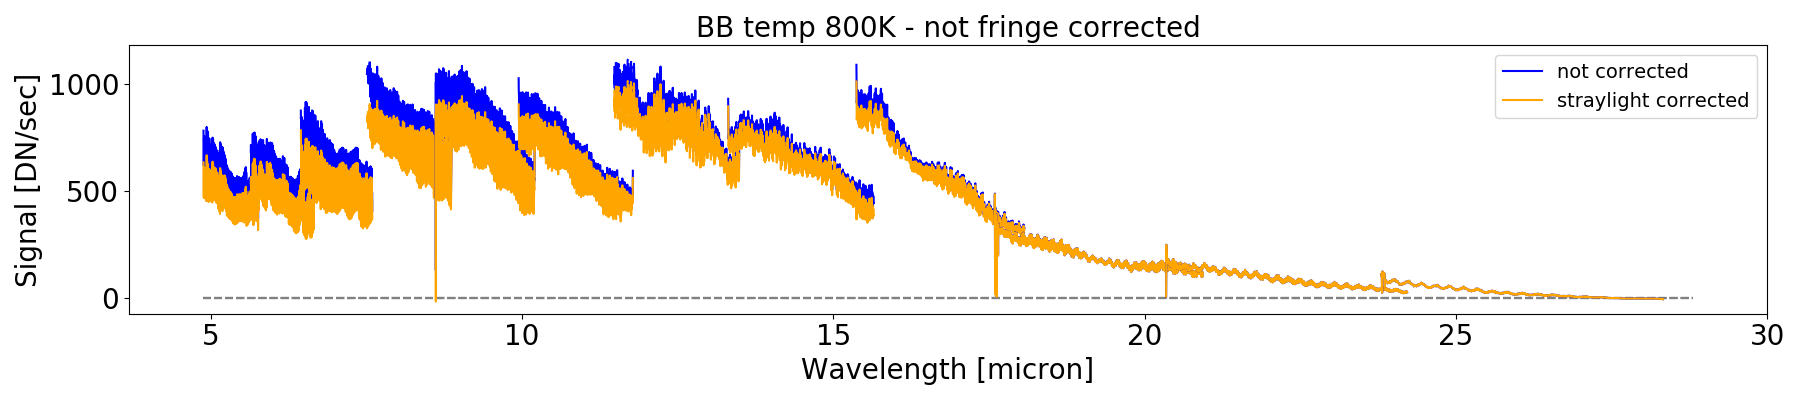

In [36]:
plt.figure(figsize=(18,4))
for band in ["1A", "1B", "1C", "2A", "2B", "2C", "3A", "3B", "3C", "4A", "4B", "4C"]:
    d2cMaps   = funcs.load_obj('d2cMaps_band{}'.format(band),path=d2cMapDir)
    ypos,xpos = funcs.detpixel_trace(band=band,d2cMaps=d2cMaps,sliceID=d2cMaps['nslices']/2,alpha_pos=0)
    plt.plot(lambdaMap[band][ypos,xpos],S_pixMap[band][ypos,xpos],'b')
    plt.plot(lambdaMap[band][ypos,xpos],S_pixMap_STRCORR[band][ypos,xpos],'orange')
    plt.hlines(0,4.88,28.8,'gray',alpha=0.4,linestyle='dashed')
legend_elements = [Line2D([0],[0],color='b',label='not corrected'),Line2D([0],[0],color='orange',label='straylight corrected')]
plt.legend(handles=legend_elements)
plt.title("BB temp 800K - not fringe corrected")
plt.xlabel('Wavelength [micron]')
plt.ylabel('Signal [DN/sec]')
plt.tight_layout()

## Remarks:
* The internal calibration source is not uniform, and as such the extracted spectrum is sensitive to which spatial position (along-slice position alpha) is plotted. For more details see Notebook 10 in https://github.com/YannisArgyriou/MIRI_FringeAdventures.git .  
  
Let's apply the fringe correction and the MRS response to the above spectrum.

In [11]:
# load 800K BB MRS response
R_pixMap = funcs.load_obj('R_pixMap',path='')['800K']
R_pixMap_STRCORR = funcs.load_obj('R_pixMap_STRCORR',path='')['800K']

<IPython.core.display.Javascript object>


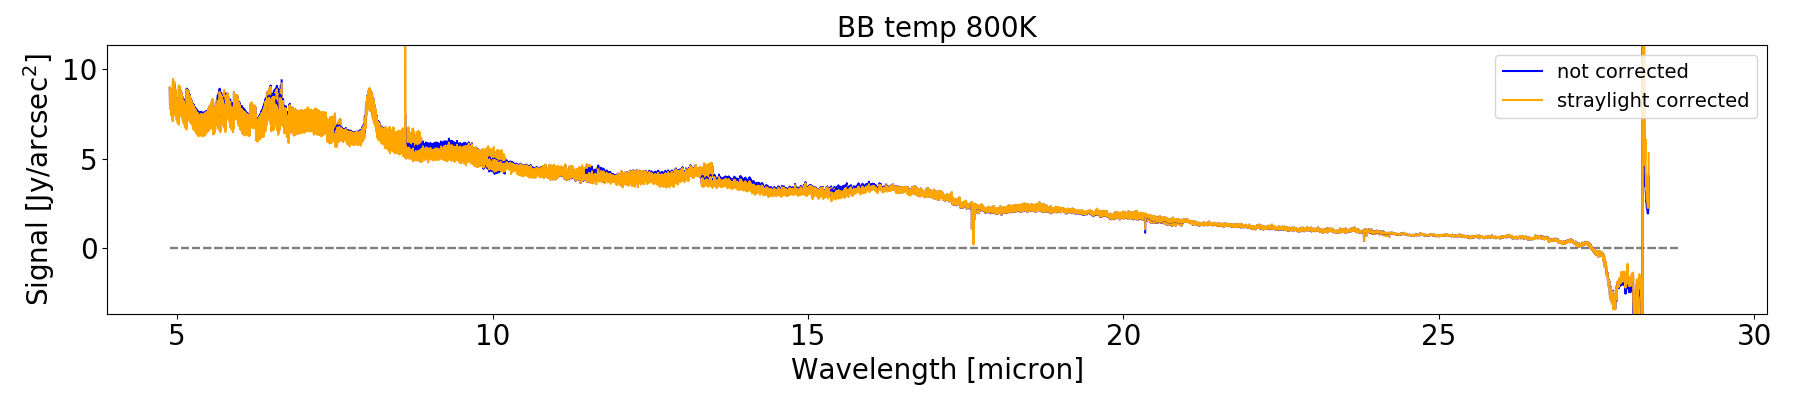

In [34]:
plt.figure(figsize=(18,4))
for band in ["1A", "1B", "1C", "2A", "2B", "2C", "3A", "3B", "3C", "4A", "4B", "4C"]:
    d2cMaps   = funcs.load_obj('d2cMaps_band{}'.format(band),path=d2cMapDir)
    ypos,xpos = funcs.detpixel_trace(band=band,d2cMaps=d2cMaps,sliceID=d2cMaps['nslices']/2,alpha_pos=0)
    fringe_img = funcs.get_cdps(band,cdpDir)[0]
    frequency  = const.c.value/ (lambdaMap[band][ypos,xpos]*10**-6)  # [s-1, or Hz]
    B_nu = (2*const.h.value*frequency**3 / const.c.value**2) * (np.exp(const.h.value*frequency/const.k_B.value/800.) -1)**-1 # [joule.s-1.m−2.Hz−1.sr−1]
    plt.plot(lambdaMap[band][ypos,xpos],S_pixMap[band][ypos,xpos]/fringe_img[ypos,xpos]/R_pixMap[band][ypos,xpos]/sizeMap[band][ypos,xpos]/1000.,'b')
    plt.plot(lambdaMap[band][ypos,xpos],S_pixMap_STRCORR[band][ypos,xpos]/fringe_img[ypos,xpos]/R_pixMap_STRCORR[band][ypos,xpos]/sizeMap[band][ypos,xpos]/1000.,'orange')
    plt.hlines(0,4.88,28.8,'gray',alpha=0.4,linestyle='dashed')
plt.ylim(-5,10)
legend_elements = [Line2D([0],[0],color='b',label='not corrected'),Line2D([0],[0],color='orange',label='straylight corrected')]
plt.legend(loc='upper right',handles=legend_elements)
plt.title("BB temp 800K")
plt.xlabel('Wavelength [micron]')
plt.ylabel(r'Signal [Jy/arcsec$^2$]')
plt.tight_layout()


## Remarks:
* Since the straylight correction both reduces the signal level and the derived MRS response level, the net effect is that the response calibrated 800K BB spectrum with and without the straylight correction applied is largely the same.
* The spatial non-uniformity of the internal calibration source affects the spectral shape in MRS bands 1A, 1B, 1C, which is dependent on the selection of the pixel trace in an MRS slice.
* There is "decent spectral continuity between bands" (purely qualitative statement), however the spectral shape in some of the bands shows systematic offsets (i.e. parabolic shapes; both concave and convex).
* At 8 microns there is a spectral feature that is introduced by virtue of the absorption band inserted into the MTSSim simulations to correct the water absorption band in the MRS spectra of extended sources during FM testing at RAL.
* After 27.4 microns the signal becomes negative because the ramps2slopes calibrated signal becomes negative.
* Applying the fringe correction (derived from the MTS extended source measurements) leaves large fringe residuals in the spectrum of the internal calibration source. For more details on the observed fringe residuals see Notebook 10 in https://github.com/YannisArgyriou/MIRI_FringeAdventures.git .

# Conclusions:
* Applying the response correction yields a blackbody curve that contains a number of defects. By improving upon the different calibration steps (e.g. during commissioning), the spectral fidelity of the internal calibration source spectrum will be improved upon.

# Follow-up question:
TBD.